# Kleven Best (2012) Replication

## Solve for the optimal tax schedule

Follow code from hamiltonian_agedep.m

First, import the data from DataPrep.jl (which is from Kleven_Best_Replication_DataPrep.ipynb). This struct has arguments z, n, $\omega_0$, fn, ntop, $\gamma$, $\delta$, $\eta$.

In [1]:
# Load libraries
using Parameters
using Plots
using Trapz
using NumericalIntegration
using SpecialFunctions
using Interpolations
using TimerOutputs
using JLD2

In [2]:
# Add libraries
# using Pkg
# Pkg.add("PyCall")

In [3]:
# Import data parameters from from prepare_data.jl
#= Previously: Run the module
include("DataPrep.jl")
using .DataPrep: prims
=#

# New: Import the JLD2 file
# Make the prims struct
@with_kw struct Prims_struct
    z
    n
    ω0
    fn
    ntop
    γ
    d
    e
    η
end;

# Load the JLD file
jldfile = load("primitives.jld2")

# Create a struct object
prims = Prims_struct(z=jldfile["z"], n=jldfile["n"], ω0=jldfile["ω0"], fn=jldfile["fn"], 
    ntop=jldfile["ntop"], γ=jldfile["γ"], d=jldfile["d"], e=jldfile["e"], η=jldfile["η"])

Prims_struct
  z: Array{Float64}((978,)) [148.4131591025766, 150.17348576416674, 151.95469163872048, 153.7570243743271, 155.5807345564264, 157.4260757426494, 159.293304498071, 161.18268043088128, 163.09446622847997, 165.0289276939985  …  1.3441792061885778e7, 1.3601224992827775e7, 1.3762548955810169e7, 1.3925786380340775e7, 1.409095996196357e7, 1.425809266541405e7, 1.4427207727812257e7, 1.4598328661893431e7, 1.4771479259276977e7, 1.4946683593774399e7]
  n: Array{Float64}((978,)) [30.263461163541827, 30.51559227444055, 30.767767586748093, 31.02003127691949, 31.27242747156859, 31.52500022271328, 31.77779348321883, 32.0308510825042, 32.284216702574916, 32.5379338544449  …  25574.210424036966, 25749.394175295412, 25925.777917283227, 26103.3698668783, 26282.178296810493, 26462.211535988918, 26643.477969824642, 26825.986040548025, 27009.744247519877, 27194.761147535384]
  ω0: Array{Float64}((978,)) [67.491388, 67.56448299394141, 67.63758654525179, 67.71070722817241, 67.78385365061185, 67.857

In the routine below, the tax schedule is solved in two loops. The outer loop satisfies th government budget constraints by changing the intercepts $T0_y$ and $T0_o$. The inner loop satisfies the optimal tax schedule $T_i(z)$ at age $i \in \{y, o\}$ described in Equation (5):

$$ \frac{\tau_i(z)}{1-\tau_i(z)} = A_i(z)B_i(z)C_i(z)$$

Where:

$$A_i(z) = \left(E_{ii} + E_{ji}\frac{\tau_j(z_j(z))z_j(z)}{\tau_i(z)z}\right)^{-1} $$

$$B_i(z) = \frac{\int_z^\infty [1-g_i(z')]dH_i(z')}{1-H_i(z)} $$

$$C_i(z) = \frac{1-H_i(z)}{zh_i(z)} $$

A few more relevent equations are:

Lifetime utility given by Equation (1):

$$U(z_y, z_o) = z_y - T_y(z_y) - \frac{1}{1+1/e} \left(\frac{z_y}{n}\right)^{1+1/e}\\
+ z_o - T_o(z_o) - \frac{1}{1+1/e} \left(\frac{z_o}{\omega(n, z_y/n)}\right)^{1+1/e}$$

CRRA social welfare function with social welfare weight $g$:

$$\Psi(U) = U^{1-\gamma}/(1-\gamma) $$
$$\implies g = \Psi'(U)/\lambda = U^{-\gamma}/\lambda$$

In [4]:
# First, some helper functions
# Helper function to mimic 'max' in Matlab
# Currently editing to make this faster
function maxdf(dta) # dta must be a matrix
    val = maximum(dta)
    ind = findfirst(dta .== val)
    return val, ind
end;

# Helper function to mimic 'find' in Matlab
function findnon0(dta)
    return findall(!=(0),vec(dta))
end;

# Helper function for linear interpolation
function limat(x, v, endpoint, xq)
    li = LinearInterpolation(x, v, extrapolation_bc = endpoint)
    return li.(xq)
end;

In [5]:
# Temporary
function maxdf2(dta)
    if size(dta)[1] == 1 # If row vector
        vals, inds = findmax(dta)
        inds = inds[2]
    elseif size(dta)[2] == 1 # If column vector
        vals, inds = findmax(dta)
        inds = inds[1]
    else # If matrix
        vals, inds = findmax(dta, dims = 1)
        inds = getindex.(inds[1,:],1)
    end
    return vals, inds
end;

In [6]:
# Function to run the inner loop
function inner_loop(prims, τ_y, τ_o, T0_y, T0_o, λ, SWF, Tax)
    
    @timeit to "Block 1" begin
    # Block 1: Individual optimization
    # Pick best combination of zy and zo in terms of lifetime utility
    # Get the tax schedule over z
    # CHECKED/WORKS
    T_yz = cumul_integrate(prims.z, τ_y) .+ T0_y
    T_oz = cumul_integrate(prims.z, τ_o) .+ T0_o

    # Empty vectors for z_i and U
    z_y = zeros(prims.ntop)
    z_o = zeros(prims.ntop)
    Un = zeros(prims.ntop)

    ee = 1 + 1/prims.e
        
    Ulife_first = repeat(prims.z', prims.ntop) - repeat(T_yz', prims.ntop) + 
                repeat(prims.z, 1, prims.ntop) - repeat(T_oz, 1, prims.ntop)
    Ulife_second = repeat(((prims.z').^ee), prims.ntop)
    Ulife_third = ((prims.z*(1 ./ prims.z.^prims.d)').^ee)

    Threads.@threads for i in 1:prims.ntop # Iterate through the ability distribution
        # NOTE: This is the slow part...
        # Compute lifetime utility from Equation (1)
        y_cons = (1/prims.n[i]^ee)/ee # Last term for y and o
        o_cons = ((1/prims.ω0[i])^ee)/ee
        # Big matrix of utilities for each z_y and z_o
        Ulife = Ulife_first - (y_cons * Ulife_second) - (o_cons * Ulife_third)
        #=
        Ulife = repeat(prims.z', prims.ntop) - repeat(T_yz', prims.ntop) + 
                repeat(prims.z, 1, prims.ntop) - repeat(T_oz, 1, prims.ntop) - 
                repeat(y_cons * ((prims.z').^ee), prims.ntop) - 
                (o_cons * ((prims.z*(1 ./ prims.z.^prims.d)').^ee))
        =#
        # Optimize
        # Re-do the optimization, hopefully faster
        # Need to check accuracy
        Ustar, zinds = maxdf(Ulife)
        z_y[i] = prims.z[zinds[2]]
        z_o[i] = prims.z[zinds[1]]
        Un[i] = Ustar
        #= Original
        U_ozy, zostarzyind = maxdf(Ulife)
        Ustar, zystarind = maxdf(U_ozy)
        # Fill in the vectors
        z_y[i] = prims.z[zystarind]
        z_o[i] = prims.z[zostarzyind[zystarind]]
        Un[i] = Ustar
        =#
    end
    end
    
    @timeit to "Block 2" begin
    # Block 2: Right-hand side of the optimality condition
    # CHECKED/WORKS
    λ0 = copy(λ)
    λ = trapz(prims.n, Un.^-prims.γ .* prims.fn) # Integral of g(z)dH(z)
    g = (Un.^-prims.γ ./ λ)
    μ = cumul_integrate(prims.n, (g .- 1) .* prims.fn) # Numerator of B
    # BC * 1/(1+e) (the 1-H(z) term cancels out)
    BC = (μ ./ (prims.n .* prims.fn)) .* ee # Divide by denominator of C
    # Find A for the young
    τ_ny = zeros(prims.ntop)
    τ_no = zeros(prims.ntop)
    Threads.@threads for i in 1:prims.ntop
        τ_ny[i] = τ_y[findfirst(prims.z .== z_y[i])]
        τ_no = τ_o[findfirst(prims.z .== z_o[i])]
    end
    A = prims.d .* ((z_o .* (1 .- τ_no)) ./ (z_y .* (1 .- τ_ny)))
    τ_nynew = BC .* (1 .+ (A .* (1 .+ prims.d .- prims.η)))
    # Do I need the missing line?
    τ_nynew = τ_nynew ./ (1 .+ τ_nynew)
    τ_nonew = BC .* (prims.η .- prims.d)
    τ_nonew = τ_nonew ./ (1 .+ τ_nonew)
    end
        
    @timeit to "Block 3" begin
    # Block 3: Tax schedule
    # CHECKED/WORKS
    τ_y_new = zeros(prims.ntop)
    τ_o_new = zeros(prims.ntop)
    for i in 1:prims.ntop # Fill in the ones we know
        τ_y_new[findfirst(prims.z .== z_y[i])] = τ_nynew[i]
        τ_o_new[findfirst(prims.z .== z_o[i])] = τ_nonew[i]
    end
    # Interpolate everything else
    # Get the non-zero values
    zfoundinzy = prims.z[findnon0(τ_y_new)]
    τ_yfound = τ_y_new[findnon0(τ_y_new)]
    zfoundinzo = prims.z[findnon0(τ_o_new)]
    τ_ofound = τ_o_new[findnon0(τ_o_new)]
    # Linearly interpolate
    τ_y_new = limat(zfoundinzy, τ_yfound, τ_yfound[1], prims.z)
    τ_o_new = limat(zfoundinzo, τ_ofound, τ_ofound[1], prims.z)
    # Fill in the top values
    topy = findfirst(prims.z .== findmax(z_y)[1])
    for j in topy:prims.ntop
        τ_y_new[j] = τ_nynew[prims.ntop]
    end
    topo = findfirst(prims.z .== findmax(z_o)[1])
    for j in topo:prims.ntop
        τ_o_new[j] = τ_nonew[prims.ntop]
    end
    # Update all the values
    Tax0 = copy(Tax)
    lifetax = z_y + z_o - Un - ((z_y./prims.n).^ee)./ee -
              ((z_o./(prims.ω0 .* (z_y.^prims.d))).^ee)./ee # Check
    Tax = trapz(prims.n, lifetax .* prims.fn)
    SWF0 = copy(SWF)
    SWF = trapz(prims.n, digamma.(Un).*prims.fn)
    end
        
    return τ_y_new, τ_o_new, λ0, λ, SWF0, SWF, Tax0, Tax
end

inner_loop (generic function with 1 method)

In [7]:
# Define the main loop
function main_loop(prims)
# Variables to iterate over
    τ_y = 0.2*ones(prims.ntop)
    τ_o = 0.2*ones(prims.ntop)
    T0_y = -70000
    T0_o = -70000
    dTax = 10000
    R = 4000 # Revenue requirement
    iter1 = 0

    while abs(dTax) > 30
        # Iterators
        iter1 += 1
        iter2 = 0
        # Negative income tax
        T0_y = T0_y - (dTax/2)
        T0_o = T0_o - (dTax/2)
        # Marginal value of public funds
        λ0 = 0
        λ = 1
        # SWF value
        SWF = 1
        SWF0 = 0
        # Tax revenue
        Tax = 1
        Tax0 = 0
        iter2 = 0

        while abs(λ0 - λ) > 0.000001 ||
        abs(SWF0 - SWF) > 0.0005 ||
        abs(Tax0 - Tax) > 50
            iter2 += 1
            τ_y, τ_o, λ0, λ, SWF0, SWF, Tax0, Tax = 
                inner_loop(prims, τ_y, τ_o, T0_y, T0_o, λ, SWF, Tax)
            println("Inner iter:", iter2, " SWF:", SWF, " Tax:", Tax, " λ:", λ)
            flush(stdout)
            #plot(prims.z, τ_y)
            #plot!(prims.z, τ_o)
        end
        dTax = Tax - R
        println("Outer iter:", iter1, " dTax:", dTax)
        flush(stdout)
    end
    return τ_y, τ_o, T0_y, T0_o, dTax
end

main_loop (generic function with 1 method)

In [8]:
# Run
# Add timer
to = TimerOutput()
τ_y, τ_o, T0_y, T0_o, dTax = main_loop(prims)

Inner iter:1 SWF:12.269582665709052 Tax:-121905.49353883721 λ:2.8781285569433857e-53
Inner iter:2 SWF:12.006514634625558 Tax:-84640.36390807912 λ:1.0861630560014676e-52
Inner iter:3 SWF:12.126995704752494 Tax:-95805.8064018106 λ:4.849169124076418e-53
Inner iter:4 SWF:12.041406359734038 Tax:-85178.5758949752 λ:8.748664068855944e-53
Inner iter:5 SWF:12.09209300503961 Tax:-90826.55044920351 λ:6.084810526646116e-53
Inner iter:6 SWF:12.057629348295574 Tax:-86601.13319669748 λ:7.797210960414281e-53
Inner iter:7 SWF:12.079136787906778 Tax:-89148.73851384596 λ:6.66940322758656e-53
Inner iter:8 SWF:12.065031787958167 Tax:-87442.18944180355 λ:7.387511331974711e-53
Inner iter:9 SWF:12.074092122556978 Tax:-88522.57129307951 λ:6.914973896890033e-53
Inner iter:10 SWF:12.068243358946571 Tax:-87790.87378181156 λ:7.21489020666407e-53
Inner iter:11 SWF:12.07201978655401 Tax:-88268.47704966324 λ:7.018239127418757e-53
Inner iter:12 SWF:12.069286866730918 Tax:-87908.68910181717 λ:7.1678179571035125e-53
Inn

([0.39696697047940377, 0.45912724069373995, 0.4971849876252785, 0.5209412848951739, 0.5415392604117186, 0.5595905557914722, 0.5704430043934866, 0.5852233162159508, 0.5942076809097525, 0.6025834149639885  …  -0.00019980287523308906, -0.00019980287523308906, -0.00019980287523308906, -0.00019980287523308906, -0.00019980287523308906, -0.00019980287523308906, -0.00019980287523308906, -0.00019980287523308906, -0.00019980287523308906, -0.00019980287523308906], [0.31711486129378935, 0.31711486129378935, 0.31711486129378935, 0.31711486129378935, 0.31711486129378935, 0.31711486129378935, 0.31711486129378935, 0.31711486129378935, 0.31711486129378935, 0.31711486129378935  …  -0.00021918083869649978, -0.00021918083869649978, -0.00021918083869649978, -0.00021918083869649978, -0.00021918083869649978, -0.00021918083869649978, -0.00021918083869649978, -0.00021918083869649978, -0.00021918083869649978, -0.00021918083869649978], -30211.853654207727, -30211.853654207727, 5.511332955403304)

In [11]:
show(to)

 ────────────────────────────────────────────────────────────────────
                            Time                    Allocations      
                   ───────────────────────   ────────────────────────
 Tot / % measured:       970s /  96.5%           2.03TiB /  99.9%    

 Section   ncalls     time    %tot     avg     alloc    %tot      avg
 ────────────────────────────────────────────────────────────────────
 Block 1       74     933s   99.6%   12.6s   2.03TiB   99.9%  28.1GiB
 Block 3       74    1.79s    0.2%  24.2ms    841MiB    0.0%  11.4MiB
 Block 2       74    1.53s    0.2%  20.7ms    791MiB    0.0%  10.7MiB
 ────────────────────────────────────────────────────────────────────

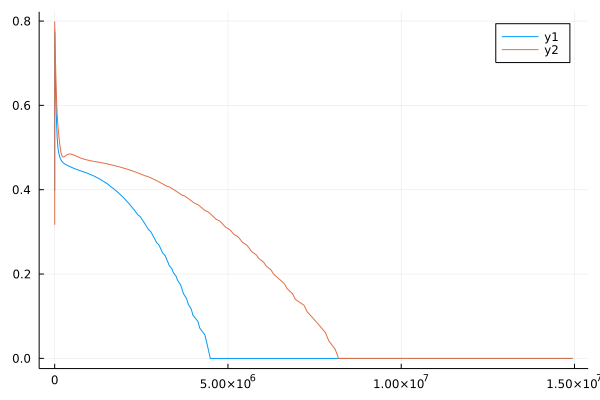

In [13]:
# Check results
plot(prims.z, τ_y)
plot!(prims.z, τ_o)